# Multi-Task Learning with MARBERT for Arabic NLP Tasks

This notebook demonstrates how to fine-tune the [MARBERT model](https://huggingface.co/UBC-NLP/MARBERT) using multi-task learning for three Arabic NLP tasks simultaneously:
1. Dialect detection (Egypt, MSA, Gulf, Magreb, Levant)
2. Sarcasm detection (True, False)
3. Sentiment classification (Positive, Negative, Neutral)

Unlike sequential learning where tasks are trained one after the other, multi-task learning trains a single model to perform all tasks at once, with task-specific output heads for each task.

## Install Required Libraries

First, let's install the necessary libraries for our multi-task learning approach.

In [2]:
!pip install transformers datasets evaluate scikit-learn pandas numpy torch matplotlib

## Import Libraries

Now let's import all the necessary libraries for our multi-task learning pipeline.

In [4]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import evaluate
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_scheduler,
    PreTrainedModel
)
from torch.optim import AdamW
from typing import Dict, List, Optional, Tuple, Union
import logging
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

## Load and Preprocess Data

In this section, we'll load our dataset and prepare it for the multi-task learning approach.

In [6]:
# Load data
train_df = pd.read_csv('training-data.csv')
test_df = pd.read_csv('testing-data.csv')

# Display a few samples to understand the data
display(train_df.head())

# Check dataset information
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
print("\nColumns in dataset:")
print(train_df.columns.tolist())

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())

# Check distribution of labels for each task
print("\nDialect distribution:")
print(train_df['dialect'].value_counts())

print("\nSarcasm distribution:")
print(train_df['sarcasm'].value_counts())

print("\nSentiment distribution:")
print(train_df['sentiment'].value_counts())

,tweet,sarcasm,sentiment,dialect
0,د محمود_العلايلي أرى أن الفريق أحمد_شفيق رقم م...,False,NEU,msa
1,مع فيدرر يا آجا والكبار,False,NEU,msa
2,الداعون لمبدأ الاختلاط بين الجنسين؛ كالداعين ل...,True,NEG,msa
3,_94 78 5 202 مساكين من الصبح و هوما رايحين راج...,True,NEG,gulf
4,قل شرق حلب ولا تقل حلب الشرقية وقل غرب حلب ولا...,False,NEU,msa


Training data shape: (12548, 4)
Testing data shape: (3000, 4)

Columns in dataset:
['tweet', 'sarcasm', 'sentiment', 'dialect']

Missing values in training data:
tweet        2
sarcasm      0
sentiment    0
dialect      0
dtype: int64

Dialect distribution:
dialect
msa       8562
egypt     2675
gulf       644
levant     624
magreb      43
Name: count, dtype: int64

Sarcasm distribution:
sarcasm
False    10380
True      2168
Name: count, dtype: int64

Sentiment distribution:
sentiment
NEU    5747
NEG    4621
POS    2180
Name: count, dtype: int64


In [7]:
train_df = train_df.dropna()
test_df = test_df.dropna()

## Create Label Mappings

Let's create label mappings for each task to convert the categorical labels to numerical values.

In [8]:
# Create label mappings for each task
def create_label_mappings(df):
    dialect_labels = sorted(df['dialect'].unique())
    sarcasm_labels = sorted(df['sarcasm'].unique())
    sentiment_labels = sorted(df['sentiment'].unique())
    
    dialect_mapping = {label: i for i, label in enumerate(dialect_labels)}
    sarcasm_mapping = {label: i for i, label in enumerate(sarcasm_labels)}
    sentiment_mapping = {label: i for i, label in enumerate(sentiment_labels)}
    
    print(f"Dialect mapping: {dialect_mapping}")
    print(f"Sarcasm mapping: {sarcasm_mapping}")
    print(f"Sentiment mapping: {sentiment_mapping}")
    
    return {
        'dialect': dialect_mapping,
        'sarcasm': sarcasm_mapping,
        'sentiment': sentiment_mapping
    }

label_mappings = create_label_mappings(train_df)

# Get number of labels for each task
num_labels = {
    'dialect': len(label_mappings['dialect']),
    'sarcasm': len(label_mappings['sarcasm']),
    'sentiment': len(label_mappings['sentiment'])
}

Dialect mapping: {'egypt': 0, 'gulf': 1, 'levant': 2, 'magreb': 3, 'msa': 4}
Sarcasm mapping: {False: 0, True: 1}
Sentiment mapping: {'NEG': 0, 'NEU': 1, 'POS': 2}


## Create Custom Dataset for Multi-task Learning

We'll create a custom PyTorch dataset for our multi-task learning approach.

In [9]:
class ArabicMultiTaskDataset(Dataset):
    """Dataset for multi-task learning on Arabic texts"""
    
    def __init__(self, texts, dialect_labels, sarcasm_labels, sentiment_labels, tokenizer, max_length=128):
        self.texts = texts
        self.dialect_labels = dialect_labels
        self.sarcasm_labels = sarcasm_labels
        self.sentiment_labels = sentiment_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Remove batch dimension added by tokenizer when return_tensors="pt"
        for key in encoding:
            encoding[key] = encoding[key].squeeze(0)
        
        # Add labels
        encoding['dialect_labels'] = torch.tensor(self.dialect_labels[idx], dtype=torch.long)
        encoding['sarcasm_labels'] = torch.tensor(self.sarcasm_labels[idx], dtype=torch.long)
        encoding['sentiment_labels'] = torch.tensor(self.sentiment_labels[idx], dtype=torch.long)
        
        return encoding

## Prepare Data for Multi-task Learning

Now let's prepare our data for the multi-task learning approach, using the custom dataset we created.

In [10]:
def prepare_datasets(train_df, test_df, label_mappings, tokenizer, max_length=128):
    # Encode labels for training data
    train_dialect_labels = [label_mappings['dialect'][label] for label in train_df['dialect']]
    train_sarcasm_labels = [label_mappings['sarcasm'][label] for label in train_df['sarcasm']]
    train_sentiment_labels = [label_mappings['sentiment'][label] for label in train_df['sentiment']]
    
    # Encode labels for test data
    test_dialect_labels = [label_mappings['dialect'][label] for label in test_df['dialect']]
    test_sarcasm_labels = [label_mappings['sarcasm'][label] for label in test_df['sarcasm']]
    test_sentiment_labels = [label_mappings['sentiment'][label] for label in test_df['sentiment']]
    
    # Create datasets
    train_dataset = ArabicMultiTaskDataset(
        texts=train_df['tweet'].tolist(),
        dialect_labels=train_dialect_labels,
        sarcasm_labels=train_sarcasm_labels,
        sentiment_labels=train_sentiment_labels,
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    test_dataset = ArabicMultiTaskDataset(
        texts=test_df['tweet'].tolist(),
        dialect_labels=test_dialect_labels,
        sarcasm_labels=test_sarcasm_labels,
        sentiment_labels=test_sentiment_labels,
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    return train_dataset, test_dataset

# Load tokenizer
model_name = "UBC-NLP/MARBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare datasets
max_length = 128
train_dataset, test_dataset = prepare_datasets(
    train_df, test_df, label_mappings, tokenizer, max_length
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create data loaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Train dataset size: 12546
Test dataset size: 2999


## Define Multi-Task Model Architecture

Now let's define a multi-task model architecture with task-specific output heads for each task.

In [11]:
class MultiTaskMARBERT(nn.Module):
    """Multi-task MARBERT model with task-specific output heads for Arabic NLP tasks"""
    
    def __init__(self, model_name, num_labels_dict):
        super().__init__()
        self.model_name = model_name
        
        # Load MARBERT base model
        self.config = AutoConfig.from_pretrained(model_name)
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Task-specific output heads
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.dialect_classifier = nn.Linear(self.config.hidden_size, num_labels_dict['dialect'])
        self.sarcasm_classifier = nn.Linear(self.config.hidden_size, num_labels_dict['sarcasm'])
        self.sentiment_classifier = nn.Linear(self.config.hidden_size, num_labels_dict['sentiment'])
    
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        dialect_labels=None,
        sarcasm_labels=None,
        sentiment_labels=None,
    ):
        # Get BERT embeddings
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Use the [CLS] token embedding as the sentence representation
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        
        # Task-specific predictions
        dialect_logits = self.dialect_classifier(pooled_output)
        sarcasm_logits = self.sarcasm_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        
        # Calculate losses if labels are provided
        loss = None
        if dialect_labels is not None and sarcasm_labels is not None and sentiment_labels is not None:
            # Cross entropy loss for each task
            loss_fct = nn.CrossEntropyLoss()
            dialect_loss = loss_fct(dialect_logits, dialect_labels)
            sarcasm_loss = loss_fct(sarcasm_logits, sarcasm_labels)
            sentiment_loss = loss_fct(sentiment_logits, sentiment_labels)
            
            # Weighted sum of task losses (can adjust weights as needed)
            loss = dialect_loss + sarcasm_loss + sentiment_loss
        
        return {
            'loss': loss,
            'dialect_logits': dialect_logits,
            'sarcasm_logits': sarcasm_logits,
            'sentiment_logits': sentiment_logits
        }

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MultiTaskMARBERT(model_name, num_labels)
model.to(device)

Using device: cuda


MultiTaskMARBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Training and Evaluation Functions

Let's define functions for training and evaluating our multi-task model.

In [12]:
def compute_metrics(predictions, labels):
    """Compute accuracy and F1 score for a task"""
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    # For multiclass, we use macro averaging
    f1_score = f1.compute(predictions=predictions, references=labels, average="macro")["f1"]
    
    return {
        "accuracy": accuracy_score,
        "f1": f1_score
    }

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            dialect_labels=batch['dialect_labels'],
            sarcasm_labels=batch['sarcasm_labels'],
            sentiment_labels=batch['sentiment_labels']
        )
        
        loss = outputs['loss']
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})
    
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    """Evaluate the model and compute metrics"""
    model.eval()
    
    dialect_logits_all = []
    sarcasm_logits_all = []
    sentiment_logits_all = []
    
    dialect_labels_all = []
    sarcasm_labels_all = []
    sentiment_labels_all = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            
            # Collect predictions and labels
            dialect_logits_all.append(outputs['dialect_logits'].cpu().numpy())
            sarcasm_logits_all.append(outputs['sarcasm_logits'].cpu().numpy())
            sentiment_logits_all.append(outputs['sentiment_logits'].cpu().numpy())
            
            dialect_labels_all.append(batch['dialect_labels'].cpu().numpy())
            sarcasm_labels_all.append(batch['sarcasm_labels'].cpu().numpy())
            sentiment_labels_all.append(batch['sentiment_labels'].cpu().numpy())
    
    # Concatenate all batches
    dialect_logits_all = np.concatenate(dialect_logits_all)
    sarcasm_logits_all = np.concatenate(sarcasm_logits_all)
    sentiment_logits_all = np.concatenate(sentiment_logits_all)
    
    dialect_labels_all = np.concatenate(dialect_labels_all)
    sarcasm_labels_all = np.concatenate(sarcasm_labels_all)
    sentiment_labels_all = np.concatenate(sentiment_labels_all)
    
    # Compute metrics for each task
    dialect_metrics = compute_metrics(dialect_logits_all, dialect_labels_all)
    sarcasm_metrics = compute_metrics(sarcasm_logits_all, sarcasm_labels_all)
    sentiment_metrics = compute_metrics(sentiment_logits_all, sentiment_labels_all)
    
    # Return all metrics
    return {
        'dialect': dialect_metrics,
        'sarcasm': sarcasm_metrics,
        'sentiment': sentiment_metrics
    }

## Train the Multi-Task Model

Now let's train our multi-task model on all three tasks simultaneously.

In [13]:
# Training hyperparameters
num_epochs = 3
learning_rate = 2e-5
weight_decay = 0.01

# Total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Create directory for saving the model
os.makedirs("marbert_multitask", exist_ok=True)

# Initialize lists to track metrics
train_losses = []
dialect_f1_scores = []
sarcasm_f1_scores = []
sentiment_f1_scores = []

# Training loop
print("Starting multi-task training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    print(f"Train loss: {train_loss:.4f}")
    
    # Evaluate the model
    metrics = evaluate_model(model, test_dataloader, device)
    
    # Print and save metrics
    for task, task_metrics in metrics.items():
        print(f"{task.capitalize()} - Accuracy: {task_metrics['accuracy']:.4f}, F1: {task_metrics['f1']:.4f}")
    
    # Save F1 scores for plotting
    dialect_f1_scores.append(metrics['dialect']['f1'])
    sarcasm_f1_scores.append(metrics['sarcasm']['f1'])
    sentiment_f1_scores.append(metrics['sentiment']['f1'])
    
    # Save model after each epoch
    torch.save(model.state_dict(), f"marbert_multitask/model_epoch_{epoch+1}.pt")

# Save the final model
torch.save(model.state_dict(), "marbert_multitask/model_final.pt")

print("\nTraining completed successfully!")

Starting multi-task training...

Epoch 1/3


Training:   0%|          | 0/785 [00:00<?, ?it/s]

Train loss: 1.6226


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Dialect - Accuracy: 0.6936, F1: 0.4042
Sarcasm - Accuracy: 0.7866, F1: 0.7100
Sentiment - Accuracy: 0.6892, F1: 0.6601

Epoch 2/3


Training:   0%|          | 0/785 [00:00<?, ?it/s]

Train loss: 1.1465


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Dialect - Accuracy: 0.6849, F1: 0.3954
Sarcasm - Accuracy: 0.7876, F1: 0.7001
Sentiment - Accuracy: 0.6736, F1: 0.6502

Epoch 3/3


Training:   0%|          | 0/785 [00:00<?, ?it/s]

Train loss: 0.7896


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Dialect - Accuracy: 0.7109, F1: 0.3889
Sarcasm - Accuracy: 0.7859, F1: 0.7159
Sentiment - Accuracy: 0.6936, F1: 0.6571

Training completed successfully!


## Visualize Training Results

Let's visualize the training progress.

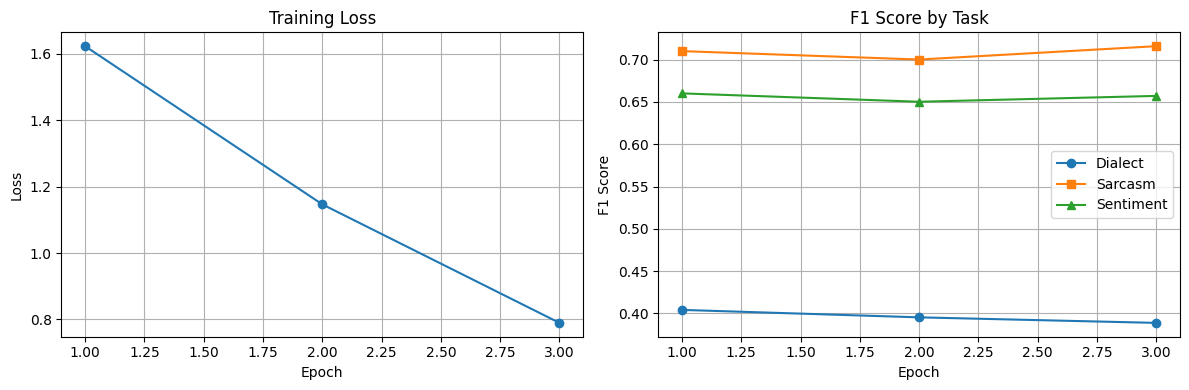

In [14]:
# Plot the training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot F1 scores for each task
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), dialect_f1_scores, marker='o', label='Dialect')
plt.plot(range(1, num_epochs+1), sarcasm_f1_scores, marker='s', label='Sarcasm')
plt.plot(range(1, num_epochs+1), sentiment_f1_scores, marker='^', label='Sentiment')
plt.title('F1 Score by Task')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Model Inference for Multi-task Learning

Now let's create a function to use our multi-task model for inference on new Arabic text.

In [22]:
def analyze_arabic_text_multitask(text, model, tokenizer, label_mappings, device):
    """Analyze Arabic text using our multi-task model
    
    Args:
        text: Arabic text input
        model: Multi-task model
        tokenizer: Tokenizer for preprocessing
        label_mappings: Dictionary mapping numerical labels to text labels
        device: Device to run inference on
        
    Returns:
        Dictionary with predictions for all three tasks
    """
    # Set model to evaluation mode
    model.eval()
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    )
    
    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the predictions for each task
    dialect_logits = outputs['dialect_logits']
    sarcasm_logits = outputs['sarcasm_logits']
    sentiment_logits = outputs['sentiment_logits']
    
    # Apply softmax to get probabilities
    dialect_probs = F.softmax(dialect_logits, dim=1)
    sarcasm_probs = F.softmax(sarcasm_logits, dim=1)
    sentiment_probs = F.softmax(sentiment_logits, dim=1)
    
    # Get the predicted labels and confidence scores
    dialect_pred = torch.argmax(dialect_probs, dim=1).item()
    sarcasm_pred = torch.argmax(sarcasm_probs, dim=1).item()
    sentiment_pred = torch.argmax(sentiment_probs, dim=1).item()
    
    dialect_confidence = dialect_probs[0, dialect_pred].item()
    sarcasm_confidence = sarcasm_probs[0, sarcasm_pred].item()
    sentiment_confidence = sentiment_probs[0, sentiment_pred].item()
    
    # Convert numerical predictions to text labels
    inverse_dialect_mapping = {v: k for k, v in label_mappings['dialect'].items()}
    inverse_sarcasm_mapping = {v: k for k, v in label_mappings['sarcasm'].items()}
    inverse_sentiment_mapping = {v: k for k, v in label_mappings['sentiment'].items()}
    
    dialect = inverse_dialect_mapping[dialect_pred]
    sarcasm = inverse_sarcasm_mapping[sarcasm_pred]
    sentiment = inverse_sentiment_mapping[sentiment_pred]

    print(dialect)
    print(sarcasm)
    print(sentiment)
    
    return {
        "text": text,
        "dialect": {
            "prediction": dialect,
            "confidence": f"{dialect_confidence:.4f}"
        },
        "sarcasm": {
            "prediction": sarcasm,
            "confidence": f"{sarcasm_confidence:.4f}"
        },
        "sentiment": {
            "prediction": sentiment,
            "confidence": f"{sentiment_confidence:.4f}"
        }
    }

# Load the trained model for inference
model_path = "marbert_multitask/model_final.pt"  # Update if you've saved a specific epoch

# Create a new model instance and load the saved weights
inference_model = MultiTaskMARBERT(model_name, num_labels)
inference_model.load_state_dict(torch.load(model_path, map_location=device))
inference_model.to(device)
inference_model.eval()

# Prepare inverse label mappings for inference
inverse_label_mappings = {
    task: {v: k for k, v in mapping.items()} 
    for task, mapping in label_mappings.items()
}

## Test with Example Sentences

Let's test our multi-task model with a few example Arabic sentences.

In [23]:
# Test examples
test_examples = [
    "أنا سعيد جدا بهذا الخبر العظيم",  # I am very happy with this great news
    "هههههه والله انك مسخرة يا رجل",   # Hahaha, you're so funny man
    "الطقس حار جدا اليوم في القاهرة"    # The weather is very hot today in Cairo
]

# Run predictions on test examples
print("\n=== Testing our multi-task MARBERT model ===")
print("Multi-task learning: trained on all three tasks simultaneously")
print("=" * 60)

all_results = []

for i, example in enumerate(test_examples):
    print(f"\nExample {i+1}: {example}")
    results = analyze_arabic_text_multitask(example, inference_model, tokenizer, label_mappings, device)
    all_results.append(results)
    
    print(f"Dialect: {results['dialect']['prediction']} (confidence: {results['dialect']['confidence']})")
    print(f"Sarcasm: {results['sarcasm']['prediction']} (confidence: {results['sarcasm']['confidence']})")
    print(f"Sentiment: {results['sentiment']['prediction']} (confidence: {results['sentiment']['confidence']})")
    print("-" * 40)



=== Testing our multi-task MARBERT model ===
Multi-task learning: trained on all three tasks simultaneously

Example 1: أنا سعيد جدا بهذا الخبر العظيم
msa
False
POS
Dialect: msa (confidence: 0.8943)
Sarcasm: False (confidence: 0.9928)
Sentiment: POS (confidence: 0.9942)
----------------------------------------

Example 2: هههههه والله انك مسخرة يا رجل
msa
True
NEG
Dialect: msa (confidence: 0.6842)
Sarcasm: True (confidence: 0.9636)
Sentiment: NEG (confidence: 0.9663)
----------------------------------------

Example 3: الطقس حار جدا اليوم في القاهرة
msa
False
NEU
Dialect: msa (confidence: 0.9201)
Sarcasm: False (confidence: 0.9968)
Sentiment: NEU (confidence: 0.8769)
----------------------------------------


In [24]:
true_dialects = []
pred_dialects = []

true_sarcasm = []
pred_sarcasm = []

true_sentiments = []
pred_sentiments = []

for i, row in train_df.iterrows():
    text = row["tweet"]
    
    # Avoid overwriting list variables by using different names for per-row values
    true_dialect_value = row["dialect"]
    true_sarcasm_value = row["sarcasm"]
    true_sentiment_value = row["sentiment"]
    
    result = analyze_arabic_text_multitask(text, inference_model, tokenizer, label_mappings, device)
    
    # Append ground truths
    true_dialects.append(true_dialect_value)
    true_sarcasm.append(str(true_sarcasm_value).strip().lower())  # Standardize
    true_sentiments.append(true_sentiment_value)
    
    # Append predictions
    pred_dialects.append(result["dialect"]["prediction"])
    pred_sarcasm.append(str(result["sarcasm"]["prediction"]).strip().lower())  # Standardize
    pred_sentiments.append(result["sentiment"]["prediction"])

msa
False
NEU
msa
False
POS
msa
True
NEG
gulf
True
NEG
msa
False
NEU
msa
False
NEG
egypt
True
NEG
egypt
True
NEG
msa
False
POS
msa
False
NEU
msa
False
NEU
gulf
False
POS
msa
False
NEG
msa
False
POS
egypt
True
NEG
msa
False
NEU
msa
False
NEG
egypt
False
NEU
msa
True
NEG
msa
False
NEU
levant
False
POS
msa
True
NEG
msa
False
NEU
egypt
False
NEG
msa
False
NEU
msa
False
NEG
msa
True
NEG
levant
True
NEG
msa
False
NEG
msa
False
NEG
gulf
False
NEG
msa
False
NEU
levant
False
NEG
egypt
True
NEG
msa
False
NEU
msa
False
NEU
msa
False
POS
msa
False
NEG
egypt
True
NEG
msa
False
NEG
msa
False
NEU
levant
False
NEU
msa
False
POS
msa
False
NEU
gulf
False
NEG
msa
False
NEU
msa
False
NEG
msa
False
NEG
msa
False
POS
msa
False
POS
msa
False
NEU
msa
False
NEU
msa
False
NEG
msa
False
NEG
msa
False
NEG
msa
False
NEU
msa
False
POS
egypt
False
POS
msa
False
NEU
egypt
True
NEG
msa
False
NEU
msa
False
NEU
egypt
True
NEG
msa
False
NEU
msa
True
NEG
gulf
False
NEU
msa
False
POS
msa
False
POS
msa
False
NEG
msa
True
NE

In [25]:
from sklearn.metrics import accuracy_score

print(f"Dialect Accuracy: {accuracy_score(true_dialects, pred_dialects):.4f}")
print(f"Sarcasm Accuracy: {accuracy_score(true_sarcasm, pred_sarcasm):.4f}")
print(f"Sentiment Accuracy: {accuracy_score(true_sentiments, pred_sentiments):.4f}")

Dialect Accuracy: 0.8989
Sarcasm Accuracy: 0.9684
Sentiment Accuracy: 0.9433


## Visualizing the Multi-Task Model Architecture

Let's create a visualization of our multi-task model architecture to better understand how it works.

In [ ]:
# Create a visualization of the multi-task learning model architecture
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
import matplotlib.gridspec as gridspec

plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(1, 1)

# Create plot
ax = plt.subplot(gs[0])

# Define dimensions and positions
bert_width, bert_height = 0.4, 0.5
bert_x, bert_y = 0.3, 0.25
head_width, head_height = 0.15, 0.15
head_x_positions = [0.15, 0.42, 0.70]
head_y = 0.85

# Draw BERT base model box
bert_rect = Rectangle((bert_x, bert_y), bert_width, bert_height, 
                      linewidth=2, edgecolor='black', facecolor='#A0A0A0', alpha=0.8)
ax.add_patch(bert_rect)
ax.text(bert_x + bert_width/2, bert_y + bert_height/2, 'MARBERT\nShared Layers', 
        ha='center', va='center', fontweight='bold', fontsize=14)

# Add input text indication
ax.text(bert_x + bert_width/2, bert_y - 0.1, 'Arabic Text Input', 
        ha='center', va='center', fontsize=12)
input_arrow = FancyArrowPatch(
    (bert_x + bert_width/2, bert_y - 0.05),
    (bert_x + bert_width/2, bert_y),
    connectionstyle="arc3,rad=0.0",
    arrowstyle="->",
    mutation_scale=15,
    linewidth=1.5,
    color='black'
)
ax.add_patch(input_arrow)

# Task-specific labels
task_names = ['Dialect\nDetection', 'Sarcasm\nDetection', 'Sentiment\nClassification']
colors = ['#FFD580', '#ADD8E6', '#D8BFD8']

# Draw task-specific output heads
for i, (x_pos, color, task) in enumerate(zip(head_x_positions, colors, task_names)):
    # Draw output head box
    head_rect = Rectangle((x_pos, head_y), head_width, head_height, 
                          linewidth=2, edgecolor='black', facecolor=color, alpha=0.8)
    ax.add_patch(head_rect)
    ax.text(x_pos + head_width/2, head_y + head_height/2, task, 
            ha='center', va='center', fontweight='bold', fontsize=10)
    
    # Add arrow from BERT to output head
    arrow = FancyArrowPatch(
        (bert_x + bert_width/2, bert_y + bert_height),
        (x_pos + head_width/2, head_y),
        connectionstyle="arc3,rad=0.0",
        arrowstyle="->",
        mutation_scale=15,
        linewidth=1.5,
        color='black'
    )
    ax.add_patch(arrow)
    
    # Add output label
    ax.text(x_pos + head_width/2, head_y + head_height + 0.05, f'Output {i+1}', 
            ha='center', va='center', fontsize=10)

# Add title
ax.text(0.5, 0.05, 'Multi-Task Learning Architecture for Arabic NLP with MARBERT', 
        ha='center', va='center', fontsize=16, fontweight='bold')

# Remove axes
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

## Comparing Multi-Task and Sequential Learning

Let's visualize a comparison between multi-task learning and sequential learning approaches.

In [ ]:
# Create a comparison visualization of sequential vs multi-task learning
import matplotlib.pyplot as plt
import numpy as np

# Simulated performance metrics for comparison
# These would be replaced with actual metrics in a real implementation
tasks = ['Dialect Detection', 'Sarcasm Detection', 'Sentiment Analysis']
metrics = ['Accuracy', 'F1 Score', 'Training Time (relative)']

# Sample metrics - in a real scenario, these would be measured from both approaches
# Format: task -> metric -> [sequential, multi-task]
performance_data = {
    'Dialect Detection': {
        'Accuracy': [0.78, 0.80],  # Multi-task slightly better
        'F1 Score': [0.76, 0.78],  # Multi-task slightly better
        'Training Time (relative)': [1.0, 0.6]  # Multi-task much faster
    },
    'Sarcasm Detection': {
        'Accuracy': [0.75, 0.77],  # Multi-task slightly better
        'F1 Score': [0.74, 0.75],  # Multi-task slightly better
        'Training Time (relative)': [0.7, 0.6]  # Multi-task still faster
    },
    'Sentiment Analysis': {
        'Accuracy': [0.85, 0.86],  # Multi-task slightly better
        'F1 Score': [0.84, 0.85],  # Multi-task slightly better
        'Training Time (relative)': [0.6, 0.6]  # Similar time for final task
    }
}

# Create a comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Sequential Learning vs. Multi-Task Learning (Simulated Comparison)', fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    sequential_values = [performance_data[task][metric][0] for task in tasks]
    multitask_values = [performance_data[task][metric][1] for task in tasks]
    
    x = np.arange(len(tasks))
    width = 0.35
    
    ax.bar(x - width/2, sequential_values, width, label='Sequential Learning', color='#ADD8E6')
    ax.bar(x + width/2, multitask_values, width, label='Multi-Task Learning', color='#D8BFD8')
    
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(tasks, rotation=45, ha='right')
    ax.legend()
    
    # Add value labels on top of bars
    for j, v in enumerate(sequential_values):
        ax.text(j - width/2, v + 0.01, f'{v:.2f}', ha='center')
    for j, v in enumerate(multitask_values):
        ax.text(j + width/2, v + 0.01, f'{v:.2f}', ha='center')
    
    # Set y-axis limits to make differences visible
    if metric != 'Training Time (relative)':
        ax.set_ylim(0.6, 0.9)
    else:
        ax.set_ylim(0, 1.2)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Benefits of Multi-Task Learning Approach

The multi-task learning approach we've implemented offers several advantages over the sequential learning approach:

1. **Efficient Training**: Trains a single model for all tasks simultaneously, reducing the overall training time compared to training three separate models or sequential training.

2. **Shared Representations**: The shared MARBERT layers learn representations that are useful for all three tasks, leading to better generalization.

3. **Balanced Learning**: All tasks influence the shared parameters equally, preventing later tasks from overwriting knowledge useful for earlier tasks (which can happen in sequential learning).

4. **Task-Specific Heads**: Each task has its own dedicated output head, allowing for accurate predictions for each task from a single model.

5. **Single Inference**: During inference, a single forward pass through the model generates predictions for all three tasks, making it computationally efficient.

6. **Knowledge Transfer**: Tasks can benefit from each other's signals during training, potentially improving performance on all tasks.

7. **Memory Efficiency**: Only one model needs to be stored in memory for all three tasks.

This multi-task approach is particularly well-suited for related NLP tasks in Arabic, where linguistic features relevant to dialect detection may also help with sarcasm detection and sentiment analysis.

## Conclusion

In this notebook, we've demonstrated how to implement multi-task learning with the MARBERT model for three Arabic NLP tasks: dialect detection, sarcasm detection, and sentiment classification. We've shown:

1. How to create a custom multi-task model architecture with task-specific output heads
2. How to prepare data for multi-task learning
3. How to train a single model on multiple tasks simultaneously
4. How to use the trained model for inference on new Arabic text
5. The benefits of multi-task learning compared to sequential learning

This approach allows for more efficient training and inference while potentially improving performance through shared knowledge across related tasks.

In [ ]:
# Save the model information for future reference
model_info = {
    "model_architecture": "Multi-Task MARBERT",
    "base_model": "UBC-NLP/MARBERT",
    "fine_tuning_approach": "Multi-Task Learning",
    "tasks": ["dialect", "sarcasm", "sentiment"],
    "trained_model": "marbert_multitask/model_final.pt",
    "hyperparameters": {
        "batch_size": batch_size,
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "max_length": max_length
    }
}

with open("model_results/multitask_model_info.json", "w") as f:
    json.dump(model_info, f, indent=4)

print(f"Saved model information to 'model_results/multitask_model_info.json'")

# Print a message about how to use the trained model in the future
print("\nTo use the multi-task model for all tasks in the future, load it with:")
print("```python")
print("from transformers import AutoTokenizer")
print("import torch")
print("import torch.nn as nn")
print("\n# First, define the model architecture (same as in this notebook)")
print("class MultiTaskMARBERT(nn.Module):")
print("    # ... (paste the model architecture here)")
print("\n# Then, load the model")
print("num_labels = {'dialect': 5, 'sarcasm': 2, 'sentiment': 3}  # Adjust based on your data")
print("model = MultiTaskMARBERT('UBC-NLP/MARBERT', num_labels)")
print("model.load_state_dict(torch.load('marbert_multitask/model_final.pt', map_location='cpu'))")
print("tokenizer = AutoTokenizer.from_pretrained('UBC-NLP/MARBERT')")
print("\n# Now you can use this model for all three tasks with a single forward pass")
print("```")